In [2]:
import os
import tensorflow as tf
import numpy as np
from sklearn.decomposition import IncrementalPCA
from tqdm import tqdm

2023-02-16 13:37:23.122034: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
subj_dir = 'subj01'
data_dir = os.path.join('./algonauts_2023_challenge_data', subj_dir)
train_img_dir  = os.path.join(data_dir, 'training_split', 'training_images')
test_img_dir  = os.path.join(data_dir, 'test_split', 'test_images')
train_img_list = os.listdir(train_img_dir)
test_img_list = os.listdir(test_img_dir)
train_img_list.sort()
test_img_list.sort()
train_img_paths = [os.path.join(train_img_dir, train_img_file) for train_img_file in train_img_list]
test_img_paths = [os.path.join(test_img_dir, test_img_file) for test_img_file in test_img_list]
print('Training images: ' + str(len(train_img_list)))
print('Test images: ' + str(len(test_img_list)))

# SHORTING THE TRAINING IMAGES FOR TESTING
train_img_paths = train_img_paths[:300]

# Preprocessing images specific to ResNet50
train_images = [tf.keras.preprocessing.image.load_img(train_img_path, target_size=(224, 224)) for train_img_path in train_img_paths]
train_images = [tf.keras.preprocessing.image.img_to_array(train_image) for train_image in train_images] # 224*224*3
train_images = [tf.keras.applications.resnet50.preprocess_input(train_image) for train_image in train_images] # 1*224*224*3 (preprocessed - what does it do exactly?)

# Loading the model
base_model = tf.keras.applications.ResNet50(weights='imagenet')
# Specifying the input and output layers
model = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

Training images: 9841
Test images: 159


In [23]:
# create a dataset from the images
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.batch(100)

In [24]:
pca = IncrementalPCA(n_components=50, batch_size=100)

# Fit PCA to batch of datastet
for batch in tqdm(train_dataset):
    print(batch.shape)
    # Extract features
    features = model.predict(batch)
    # Flatten the features
    features = features.reshape(features.shape[0], -1)
    # Fit PCA to batch of features
    pca.partial_fit(features)

  0%|          | 0/3 [00:00<?, ?it/s]

(100, 224, 224, 3)
4/4 [==============================] - 14s 3s/step


 33%|███▎      | 1/3 [00:14<00:28, 14.10s/it]

(100, 224, 224, 3)
4/4 [==============================] - 12s 3s/step


 67%|██████▋   | 2/3 [00:26<00:12, 12.81s/it]

(100, 224, 224, 3)
4/4 [==============================] - 11s 3s/step


100%|██████████| 3/3 [00:37<00:00, 12.43s/it]


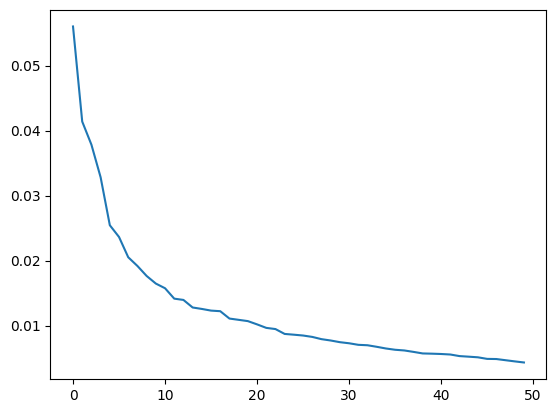

In [28]:
import matplotlib.pyplot as plt
# plot pca scree plot
plt.plot(pca.explained_variance_ratio_)